# Predición de Datos de Zika usando datos meteorológicos y demográficos

In [ ]:
import pandas
import geo_python
import time 
import geopy
import os
from geopy.geocoders import Bing


In [37]:
datos=pandas.read_csv("/home/mario/datos_unicos.csv")

address ="Colombia-Atlantico-Soledad" #prueba con un dato para ver si funciona

bing_key = "AnuzsHFGryWZ8aLEfc-n9rVcY5pjNHwUUQJeW0L7XQaQUQc4Y0WWwr2EbDqnfpAh"

In [ ]:
geolocator = Bing(api_key=bing_key, timeout=4, scheme = 'http')
location = geolocator.geocode(address)
print((location.latitude, location.longitude))

La siguiente función determina la longitud y latitud de cada uno de los 1122 municipios

In [ ]:
location_lat = []
location_lon = []
count=0
for i in datos["X"]:
    location = geolocator.geocode(i)
    if location is None:
        location_lat.append(-1)
        location_lon.append(-1)
    else :
        location_lat.append(location.latitude)
        location_lon.append(location.longitude)
    time.sleep(0.5)

In [ ]:
len(location2_lon) ## Validamos la longitud de los datos

In [ ]:
datos['Longitud']=location_lon
datos['Latitud']= location_lat ## Guardamos los datos en la data frame

In [ ]:
datos.to_csv("analisis.csv") ## Guardamos en csv para mantener los datos seguros
analisis = datos ## originalmente esto no estaba en el codigo, el analisis se abrio luego del csv, se agrega para compatibilidad

En este punto tenemos los datos, pero están sucios. Por esta razón procedemos a limpiar, se eliminan los signos de porcentaje y se pasa todo a float

In [ ]:
for n in ['COBERTURA_NETA','SEDES_CONECTADAS_A_INTERNET', 'DESERCIÓN', "TASA_MATRICULACIÓN_5_16", "MORTALIDAD_INFANTIL_POR_MIL_NACIDOS", "NBI"]:
    for i in range(len(analisis[n])):
        analisis[n][i]=float(str(analisis[n][i]).replace("%", ""))

Se eliminan los null, se cambian por ceros

In [ ]:
for i in list((analisis.isnull()).columns):
    for n in (range(len((analisis.isnull())[i]))):
        if analisis.isnull()[i][n]==True:
            analisis[i][n] = 0

Se cuentan los null para comprobar

In [ ]:
analisis.isnull().sum().sum()

Se guarda

In [ ]:
analisis.to_csv("Base_data.csv")

Esta función permite tomar los valores de Zika de los archivos reportados

In [76]:
def get_zika_data(archivo):
    import pandas
    temp_file = pandas.read_csv(archivo)
    result_data = [[],[]]
    for i in range(len(list(temp_file["data_field"]))):
        if temp_file["data_field"][i] == 'zika_confirmed_laboratory':
            result_data[0].append((temp_file["location"][i]).upper())
            result_data[1].append(temp_file['value'][i])
    return result_data
    

In [91]:

## Esta Funcion toma los archivos de reporte de Zika y da una lista de las fechas y tambien una lista de los archivos
def date_parse(Zika_files):
    import os
    fechas = []
    filenames = []
    for i in sorted(os.listdir(Zika_files), key=str.lower):
        #print(i)
        if i.startswith('Muni'):
            start = i.find('_Zika_') + 6
            end = i.find('.csv', start)
            fecha=i[start:end]
            fechas.append(fecha)
            filenames.append(str(Zika_files + i))
    return fechas, filenames

## Esta funcion (muy sencilla pero util para recordar), pasa el formato de una fecha al usado en los arhivos de NASA
def date_NASA(date):
    return date.replace("-","")
def name_parse(name):
    name_ok = (((name.replace("Ñ","N")).replace("LA_GUAJIRA","GUAJIRA")).replace("COLOMBIA-TOLIMA-ARMERO_","COLOMBIA-TOLIMA-ARMERO")).replace('COLOMBIA-ATLANTICO-BARRANQUILLA', 'COLOMBIA-BARRANQUILLA-BARRANQUILLA')
    return name_ok


## Esta funcion da los nombres de los archivos de un anno especifico para los datos de NASA. Se modifico para que de solo 11 meses, dado 
def set_archive(dirname,year):
    import os
    day_count =1
    name_list=[]
    for i in range(1,13):
        day_count = 1
        for filename in os.listdir(dirname + str(i).zfill(2) + "/"):
            root, ext = os.path.splitext(filename)
            temp_str= str(year)+str(i).zfill(2)+str(day_count).zfill(2)
            if temp_str in root and ext == '.tif':
                name_list.append(dirname + str(i).zfill(2) + "/" + filename)
                day_count+=1
            else:
                next
    return name_list
## Esta Funcion toma los datos de un archivo de precipitacion y los lee en cierta longitud y latitud 
def get_data(x,y,z):
    import gdal
    import gdalconst
    import numpy

    filename = str(x)

    dataset = gdal.Open(filename, gdalconst.GA_ReadOnly)

    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    bands = dataset.RasterCount
    driver = dataset.GetDriver().LongName

    band = dataset.GetRasterBand(1)

    data = band.ReadAsArray(0, 0, dataset.RasterXSize, dataset.RasterYSize).astype(numpy.float)
    ## Esta funcion solo sirve para datos de Colombia por el arreglo de las coordenadas, hemisferio norte y longitud oeste.
    return data[(180 + (int(y)*10)), int(90-(int(z)*10))]


En un análisis exploratorio previo se observa que varios nombres de departamentos no están escritos de igual forma en ambas fuentes. Por esta razón se corre una comparación de los nombres y se anotan las correcciones principales. Sin embargo, no todos los archivos tienen la misma denominación para un mismo departamento, por lo que se incluye también tolerancia a errores en el código.

In [96]:
palabras_mal = ["Ü","Ñ", "COLOMBIA-TOLIMA-ARMERO_", "LA_GUAJIRA", "COLOMBIA-ATLANTICO-BARRANQUILLA", "COLOMBIA-BOGOTA_D_C.-BOGOTA_D.C." , "COLOMBIA-BOLIVAR-CARTAGENA_DE_INDIAS", "COLOMBIA-MAGDALENA-CERRO_DE_SAN_ANTONIO", "COLOMBIA-MAGDALENA-CHIVOLO", "COLOMBIA-META-SAN_LUIS_DE_CUBARRAL", "COLOMBIA-ANTIOQUIA-DONMATIAS", "COLOMBIA-CHOCO-EL_CANTON_SAN_PABLO", "COLOMBIA-CHOCO-EL_LITORAL_SAN_JUAN", "COLOMBIA-PUTUMAYO-PUERTO_LEGUIZAMO", "COLOMBIA-CAUCA-LOPEZ_DE_MICAY","COLOMBIA-CESAR-MANAURE_BALCON_DEL_CESAR", "COLOMBIA-TOLIMA-SAN_SEBASTIAN_DE_MARIQUITA", "COLOMBIA-ARCHIPIELAGO_DE_SAN_ANDRES_PROVIDENCIA_Y_SANTA_CATALINA-PROVIDENCIA", "COLOMBIA-CORDOBA-PURISIMA_DE_LA_CONCEPCION", "COLOMBIA-ARCHIPIELAGO_DE_SAN_ANDRES_PROVIDENCIA_Y_SANTA_CATALINA-SAN_ANDRES", "COLOMBIA-CORDOBA-SAN_ANDRES_DE_SOTAVENTO", "COLOMBIA-ANTIOQUIA-SAN_JOSE_LA_MONTANA", "COLOMBIA-CUNDINAMARCA-SAN_JUAN_DE_RIOSECO", "COLOMBIA-ANTIOQUIA-SAN_PEDRO_LOS_MILAGROS", "COLOMBIA-ANTIOQUIA-SAN_VICENTE_FERRER", "COLOMBIA-MAGDALENA-SANTA_MARTA", "COLOMBIA-ANTIOQUIA-SANTA_FE_DE_ANTIOQUIA", "COLOMBIA-CUNDINAMARCA-VILLA_DE_DE_UBATE"]
palabras_bien = ["U", "N", "COLOMBIA-TOLIMA-ARMERO", "GUAJIRA", "COLOMBIA-BARRANQUILLA-BARRANQUILLA", "COLOMBIA-BOGOTA-BOGOTA,_D.C.", "COLOMBIA-CARTAGENA-CARTAGENA", "COLOMBIA-MAGDALENA-CERRO_SAN_ANTONIO", "COLOMBIA-MAGDALENA-CHIBOLO", "COLOMBIA-META-CUBARRAL", "COLOMBIA-ANTIOQUIA-DON_MATIAS", "COLOMBIA-CHOCO-EL_CANTON_DEL_SAN_PABLO", "COLOMBIA-CHOCO-EL_LITORAL_DEL_SAN_JUAN", "COLOMBIA-PUTUMAYO-LEGUIZAMO", "COLOMBIA-CAUCA-LOPEZ","COLOMBIA-CESAR-MANAURE", "COLOMBIA-TOLIMA-MARIQUITA", "COLOMBIA-SAN_ANDRES-PROVIDENCIA", "COLOMBIA-CORDOBA-PURISIMA", "COLOMBIA-SAN_ANDRES-SAN_ANDRES", "COLOMBIA-CORDOBA-SAN_ANDRES_SOTAVENTO", "COLOMBIA-ANTIOQUIA-SAN_JOSE_DE_LA_MONTANA", "COLOMBIA-CUNDINAMARCA-SAN_JUAN_DE_RIO_SECO", "COLOMBIA-ANTIOQUIA-SAN_PEDRO", "COLOMBIA-ANTIOQUIA-SAN_VICENTE", "COLOMBIA-STA_MARTA_D.E.-SANTA_MARTA", "COLOMBIA-ANTIOQUIA-SANTAFE_DE_ANTIOQUIA", "COLOMBIA-CUNDINAMARCA-VILLA_DE_SAN_DIEGO_DE_UBATE"]

In [97]:
def correct_name(name):
    for i in range(len(palabras_mal)):
        name = name.replace(palabras_mal[i], palabras_bien[i])
    return name
    

In [60]:
dates,Zika_files = date_parse('/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/')
datos= '/media/mario/TOSHIBA EXT/Climate_data/second_try/jsimpson.pps.eosdis.nasa.gov/NRTPUB/imerg/gis/2016/'
files=set_archive(datos,2016)

In [61]:
Zika_files

['/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-01-09.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-01-16.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-01-23.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-01-30.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-02-06.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-02-13.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-02-20.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-02-27.csv',
 '/media/mario/TOSHIBA EXT/Zika_data/zika/Colombia/Municipality_Zika/data/Municipality_Zika_2016-03-05.csv',
 '/media/mario/TOSH

In [26]:
# Se toman los archivos que se desean usar 
NASA_archives=[]
for i in files:
    for n in dates:
        if date_NASA(n) in i:
            #print(n)
            #print(i)
            NASA_archives.append(i)

In [30]:
get_data(NASA_archives[1], -75.4272918701172, 5.78950977325439) ## Probando la funcion para comprobar que sirve

508.0

Se utilizaran los datos que tengan al menos 3 fechas anteriores con datos de lluvia

In [138]:

import pandas
Base_data = pandas.read_csv('/home/mario/Music/Base_data.csv')
Base_table = pandas.read_csv("/home/mario/Base_table.csv")
for i in range(len(NASA_archives)):
    if i>1:
        Base_data = pandas.read_csv('/home/mario/Music/Base_data.csv')
        print("Analizando tabla "+ str(i))
        temp_table = Base_data
        temp_table.insert(len(list(Base_data.columns)), "Lluvia-7d-prev", [0]*len(Base_data["NAME"]))
        temp_table.insert(len(list(Base_data.columns)), "Lluvia-14d-prev", [0]*len(Base_data["NAME"]))
        temp_table.insert(len(list(Base_data.columns)), "Lluvia-21d-prev", [0]*len(Base_data["NAME"]))
        temp_table.insert(len(list(Base_data.columns)), "Casos_Zika", [0]*len(Base_data["NAME"]))
        temp_zika_data = get_zika_data(Zika_files[i])                                                                       
        for n in range(len(list(Base_data['NAME']))):
            if n%200 == 0:
                print("Completando " +str(n)+ " iteraciones del item " + str(i))
            temp_table['Lluvia-7d-prev'][n] = get_data(NASA_archives[i], Base_data['LON'][n], Base_data['LAT'][n])
            temp_table['Lluvia-14d-prev'][n] = get_data(NASA_archives[i-1], Base_data['LON'][n], Base_data['LAT'][n])                                                 
            temp_table['Lluvia-21d-prev'][n] = get_data(NASA_archives[i-2], Base_data['LON'][n], Base_data['LAT'][n])
            if correct_name((temp_table["NAME"][n]).upper()) in temp_zika_data[0]:
                temp_table['Casos_Zika'][n] = temp_zika_data[1][temp_zika_data[0].index(correct_name((temp_table["NAME"][n]).upper()))]  
            else:
                print("Error, no se encontro " +str(correct_name((temp_table["NAME"][n]).upper()))+ ", se colocara valor 0 en casos de Zika")
                temp_table['Casos_Zika'][0]=0
        temp_table=temp_table[temp_table.columns.difference(['LON'])]
        temp_table=temp_table[temp_table.columns.difference(['LAT'])]
        ruta = str("/home/mario/Documents/Resultados/resultados" + dates[i] + ".csv")
        temp_table.to_csv(ruta, index = False)
        Base_table.append(temp_table, ignore_index=True)
Final_table = Base_table
Final_table.to_csv("/home/mario/Documents/Resultados_finales.csv", index = False)

Analizando tabla 2
Completando 0 iteraciones del item 2


/usr/lib/python3/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3/dist-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Completando 200 iteraciones del item 2
Completando 400 iteraciones del item 2
Error, no se encontro COLOMBIA-SANTANDER-GUEPSA, se colocara valor 0 en casos de Zika


/usr/lib/python3/dist-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3/dist-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Error, no se encontro COLOMBIA-NARINO-MAGUI, se colocara valor 0 en casos de Zika
Completando 600 iteraciones del item 2
Error, no se encontro COLOMBIA-ANTIOQUIA-PENOL, se colocara valor 0 en casos de Zika
Completando 800 iteraciones del item 2
Completando 1000 iteraciones del item 2
Analizando tabla 3
Completando 0 iteraciones del item 3
Error, no se encontro COLOMBIA-BOGOTA-BOGOTA,_D.C., se colocara valor 0 en casos de Zika
Completando 200 iteraciones del item 3
Completando 400 iteraciones del item 3
Error, no se encontro COLOMBIA-SANTANDER-GUEPSA, se colocara valor 0 en casos de Zika
Error, no se encontro COLOMBIA-NARINO-MAGUI, se colocara valor 0 en casos de Zika
Completando 600 iteraciones del item 3
Error, no se encontro COLOMBIA-ANTIOQUIA-PENOL, se colocara valor 0 en casos de Zika
Completando 800 iteraciones del item 3
Completando 1000 iteraciones del item 3
Analizando tabla 4
Completando 0 iteraciones del item 4
Completando 200 iteraciones del item 4
Completando 400 iteracione

En este punto se encuentra un error relacionado a que la función anterior no da correctamente el resultado, sin embargo todos los archivos .csv son generados como se esperaba. Gracias a esto la siguiente función lee estos resultados y genera la tabla final

In [38]:
import os
import pandas
Final_table=pandas.DataFrame()

for i in range(len(os.listdir("/home/mario/Documents/Resultados/"))):
    t_file="/home/mario/Documents/Resultados/" + str(os.listdir("/home/mario/Documents/Resultados/")[i])
    tt=pandas.read_csv(t_file)
    Final_table = pandas.concat([Final_table,tt],verify_integrity=False,ignore_index=True)

    
    


In [39]:
Final_table

,COBERTURA_NETA,Casos_Zika,DESERCIÓN,Lluvia-14d-prev,Lluvia-21d-prev,Lluvia-7d-prev,MORTALIDAD_INFANTIL_POR_MIL_NACIDOS,NAME,NBI,POBLACIÓN_5_16,SEDES_CONECTADAS_A_INTERNET,TASA_MATRICULACIÓN_5_16
0,90.89,0,3.26,117,123,84,15.52,Colombia-Antioquia-Abejorral,33.85,3829,71.43,90.89
1,65.19,5,2.17,268,199,27,16.00,Colombia-Norte_Santander-Abrego,48.44,9460,7.46,65.19
2,90.50,0,0.51,60,282,205,17.59,Colombia-Antioquia-Abriaqui,28.54,400,45.45,90.50
3,116.16,87,4.80,35,79,31,20.77,Colombia-Meta-Acacias,22.68,14688,46.15,116.24
4,121.28,0,3.37,67,184,398,27.72,Colombia-Choco-Acandi,49.25,2401,22.22,121.28
5,82.38,5,4.81,1144,102,66,30.54,Colombia-Huila-Acevedo,64.10,9048,25.00,82.38
6,98.45,0,1.07,119,157,16,36.58,Colombia-Bolivar-Achi,80.74,5474,28.77,98.45
7,87.38,13,5.80,568,150,88,22.45,Colombia-Huila-Agrado,44.92,2338,40.91,87.38
8,88.21,5,5.53,224,205,15,16.61,Colombia-Cundinamarca-Agua_de_Dios,20.67,2145,0.00,88.21
9,92.05,56,3.82,288,271,4,19.79,Colombia-Cesar-Aguachica,41.90,22958,49.35,92.19


In [32]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
%matplotlib inline



In [22]:
train_data, test_data = train_test_split(Final_table[Final_table.columns.difference(['NAME'])], test_size=0.3)

X_test=test_data[test_data.columns.difference(['Casos_Zika'])]
y_test=test_data['Casos_Zika']

X_train=train_data[train_data.columns.difference(['Casos_Zika'])]
y_train=train_data['Casos_Zika']

training_acc = []
test_acc = []



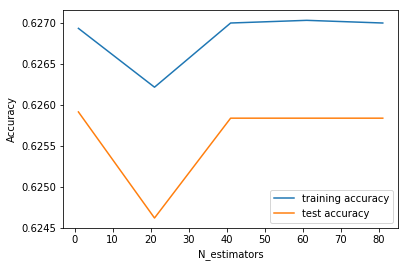

In [17]:
training_accuracy= []
test_accuracy =[]
n_estimators = range(1, 100,20)
for n in n_estimators:
    
    adb = AdaBoostClassifier(n_estimators= n)
    adb.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(adb.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(adb.score(X_test, y_test))
plt.plot(n_estimators, training_accuracy, label="training accuracy")
plt.plot(n_estimators, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("N_estimators")
plt.legend()

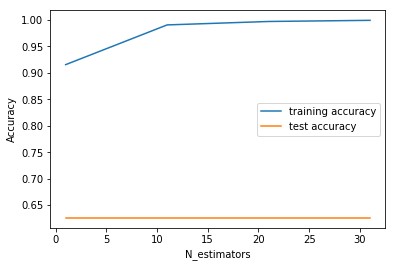

In [18]:
training_accuracy= []
test_accuracy =[]
n_estimators = range(1, 40,10)
for n in n_estimators:
    
    rfc = RandomForestClassifier(n_estimators=n)
    rfc.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(rfc.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(adb.score(X_test, y_test))
plt.plot(n_estimators, training_accuracy, label="training accuracy")
plt.plot(n_estimators, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("N_estimators")
plt.legend()

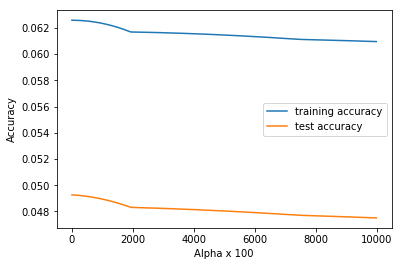

In [32]:
from sklearn.linear_model import Lasso

training_accuracy= []
test_accuracy =[]
alphas = range(1,10000,10)
for n in alphas:
    
    lass = Lasso(alpha=(n/1000))
    lass.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(lass.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(lass.score(X_test, y_test))
plt.plot(alphas, training_accuracy, label="training accuracy")
plt.plot(alphas, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Alpha x 100")
plt.legend()

0.0570780927257


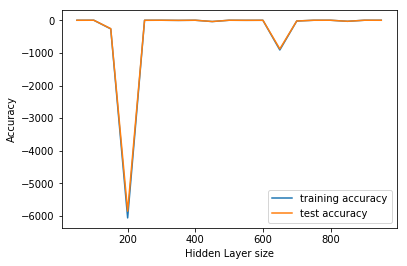

In [33]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
iter_predict = range(50, 1000,50)
for n in iter_predict:
    
    mlp = MLPRegressor(hidden_layer_sizes = (n,))
    mlp.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(mlp.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(mlp.score(X_test, y_test))
plt.plot(iter_predict, training_accuracy, label="training accuracy")
plt.plot(iter_predict, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Hidden Layer size")
plt.legend()
print(max(test_accuracy))

0.0670872919394


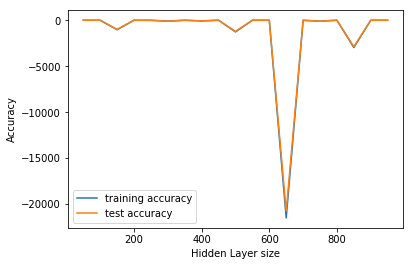

In [34]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
iter_predict = range(50, 1000,50)
for n in iter_predict:
    
    mlp = MLPRegressor(hidden_layer_sizes = (n,),warm_start=True)
    mlp.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(mlp.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(mlp.score(X_test, y_test))
plt.plot(iter_predict, training_accuracy, label="training accuracy")
plt.plot(iter_predict, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Hidden Layer size")
plt.legend()
print(max(test_accuracy))


In [37]:
print(test_accuracy.index(max(test_accuracy)))
print(iter_predict[11])

11
600


0.0649701630362


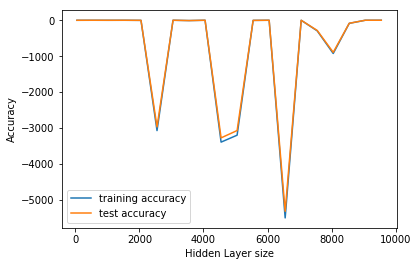

In [40]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
iter_predict = range(50, 10000, 500)
for n in iter_predict:
    
    mlp = MLPRegressor(hidden_layer_sizes = (600,),alpha = (n/1000),warm_start=True)
    mlp.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(mlp.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(mlp.score(X_test, y_test))
plt.plot(iter_predict, training_accuracy, label="training accuracy")
plt.plot(iter_predict, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Hidden Layer size")
plt.legend()
print(max(test_accuracy))


Se hará un grid search simple para determinar el mejor valor de una red de 2 capas

In [45]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
test_max=(0,0,0)
train_max=(0,0,0)
iter_predict = range(1,1000,100)
for n in range(len(iter_predict)):
    test_accuracy.append([])
    training_accuracy.append([])
    for i in range(len(iter_predict)):
        mlp = MLPRegressor(hidden_layer_sizes = (iter_predict[n],iter_predict[i]),warm_start=True)
        mlp.fit(X_train, y_train)
        # se almacena el "training set accuracy"
        training_accuracy[n].append(mlp.score(X_train, y_train))
        # se almacena la "generalization accuracy"
        test_accuracy[n].append(mlp.score(X_test, y_test))
        if mlp.score(X_test, y_test) > test_max[0]:
            test_max = (mlp.score(X_test, y_test),iter_predict[n],iter_predict[i])
        if mlp.score(X_train, y_train) > train_max[0]:
            test_max = (mlp.score(X_train, y_train),iter_predict[n],iter_predict[i])
            
print(train_max)
print(test_max)


(0, 0, 0)
(0.039289697471293072, 901, 801)


Los datos siguientes no corrieron luego de 8 horas por lo que quedan pendientes de realizar para ver si se puede mejorar el score con más layers

In [ ]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
test_max=(0,0,0,0)
train_max=(0,0,0,0)
iter_predict = range(1,100,20)
for n in range(len(iter_predict)):
    test_accuracy.append([])
    training_accuracy.append([])
    for i in range(len(iter_predict)):
        print(i,n)
        for j in range(len(iter_predict)):
            mlp = MLPRegressor(hidden_layer_sizes = (iter_predict[n],iter_predict[i],iter_predict[j]),warm_start=True)
            mlp.fit(X_train, y_train)
            # se almacena el "training set accuracy"
            training_accuracy[n].append(mlp.score(X_train, y_train))
            # se almacena la "generalization accuracy"
            test_accuracy[n].append(mlp.score(X_test, y_test))
            if mlp.score(X_test, y_test) > test_max[0]:
                test_max = (mlp.score(X_test, y_test),iter_predict[n],iter_predict[i],iter_predict[j])
            if mlp.score(X_train, y_train) > train_max[0]:
                test_max = (mlp.score(X_train, y_train),iter_predict[n],iter_predict[i],iter_predict[j])
            
print(train_max)
print(test_max)


In [ ]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
test_max=(0,0,0,0,0)
train_max=(0,0,0,0,0)
iter_predict = range(1,100,50)
for n in range(len(iter_predict)):
    test_accuracy.append([])
    training_accuracy.append([])
    for i in range(len(iter_predict)):
        for j in range(len(iter_predict)):
            for m in range(len(iter_predict)):
                mlp = MLPRegressor(hidden_layer_sizes = (iter_predict[n],iter_predict[i],iter_predict[j],iter_predict[m]),warm_start=True)
                mlp.fit(X_train, y_train)
                # se almacena el "training set accuracy"
                training_accuracy[n].append(mlp.score(X_train, y_train))
                # se almacena la "generalization accuracy"
                test_accuracy[n].append(mlp.score(X_test, y_test))
                if mlp.score(X_test, y_test) > test_max[0]:
                    test_max = (mlp.score(X_test, y_test),iter_predict[n],iter_predict[i],iter_predict[j],iter_predict[m])
                if mlp.score(X_train, y_train) > train_max[0]:
                    test_max = (mlp.score(X_train, y_train),iter_predict[n],iter_predict[i],iter_predict[j],iter_predict[m])
            
print(train_max)
print(test_max)


In [36]:
Final_table2= Final_table
#Final_table2.insert(len(list(Final_table2.columns)), "Casos_Zika_poblacion", [0]*len(Final_table2["NAME"]))
for i in range(len(Final_table2['Casos_Zika'])):
    Final_table2["Casos_Zika_poblacion"][i] = Final_table2["Casos_Zika"][i]/Final_table2['POBLACIÓN_5_16'][i]
    

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-2.44842013951


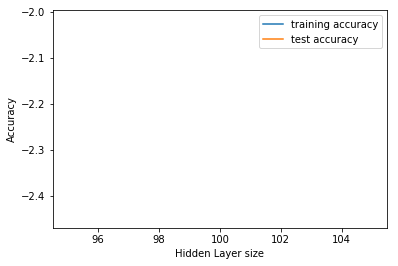

In [24]:
from sklearn.neural_network import MLPRegressor
training_accuracy= []
test_accuracy =[]
iter_predict = [100]
for n in iter_predict:
    
    mlp = MLPRegressor(hidden_layer_sizes = (n,),warm_start=True)
    mlp.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(mlp.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(mlp.score(X_test, y_test))
#plt.plot(iter_predict, training_accuracy, label="training accuracy")
#plt.plot(iter_predict, test_accuracy, label="test accuracy")
#plt.ylabel("Accuracy")
#plt.xlabel("Hidden Layer size")
#plt.legend()
print(max(test_accuracy))
